In [1]:
from collections import defaultdict
import itertools as itt
import pathlib as pl
from configparser import ConfigParser

import pandas as pd
from IPython.display import Image

import joblib as jl
import numpy as np
import scipy.stats as sst
import statsmodels.api as sm
from statsmodels.formula.api import ols
import plotly.express as px
import plotly.graph_objs as go
from plotly.subplots import make_subplots
from webcolors import name_to_hex

from src.root_path import config_path, root_path
from src.utils.dataframes import add_classified_contexts
from src.utils.tools import get_quantile_means
from src.visualization.palette import *

# context metric distribution and comparison between regions and transition pairs
### Load and format all required data, i.e. a dataframe

In [2]:
config = ConfigParser()
config.read_file(open(config_path / 'settings.ini'))
meta = {'reliability': 0.1,  # r value
        'smoothing_window': 0,  # ms
        'raster_fs': 20,
        'zscore': True,
        'stim_type': 'permutations',
        }
alpha = 0.05
montecarlos = 11000

summary_DF_file = pl.Path(config['paths']['analysis_cache']) / '220520_minimal_DF'

### same example cell as in figure 1 ###
probe = 3 #
ctx_pair = (0,1) # pair of contexts to compare and exemplify d'
cellid = 'ARM021b-36-8'

In [3]:
def print_percentage_significant():
    DF = jl.load(summary_DF_file).query(
        "analysis == 'SC' and mult_comp_corr == 'bf_cp' and metric in 'integral' "
        "and value < 10000")
    # number proportion of significant instances
    nsignif = np.sum(DF.value.values>0)
    ntotal  = DF.shape[0]
    print(f'{nsignif}/{ntotal}, {nsignif/ntotal*100:.3f}% significant  instances')

    # proportion of neurons with at least one signif instance
    neusig = DF.groupby('id').agg(modulated=('value', lambda x: np.any(x>0)))
    nsignif = np.sum(neusig.modulated.values)
    ntotal  = neusig.shape[0]
    print(f'{nsignif}/{ntotal}, {nsignif/ntotal*100:.3f}% modulated neurons')

print_percentage_significant()

45905/502537, 9.135% significant  instances
1233/1724, 71.520% modulated neurons


In [4]:

DF = jl.load(summary_DF_file).query(
    "analysis == 'SC' and mult_comp_corr == 'bf_cp' and metric in ['integral', 'last_bin'] "
    "and value > 0 and value < 10000")
# DF.loc[DF['value']>10000, 'value'] = 10000 # kinda solve outrageous outliers
DF = add_classified_contexts(DF)
assert np.all(~DF.duplicated(subset=['region', 'site', 'context_pair', 'probe', 'id', 'metric']).values)
pivoted = DF.pivot_table(index=['region', 'site', 'context_pair', 'probe', 'trans_pair', 'id'],
                         columns=['metric'], values='value', aggfunc='first').reset_index()

# adds a small amount of jitter to the last bin value to help visualization
binsize = 1 / meta['raster_fs']
jitter = (np.random.random(pivoted.shape[0]) * binsize * 0.8 - (binsize * 0.8 / 2)) * 1000  # in ms
pivoted['last_bin_jittered'] = pivoted['last_bin'] + jitter


# Panels

In [5]:
panels = defaultdict(list)

## scatter plot of all dots

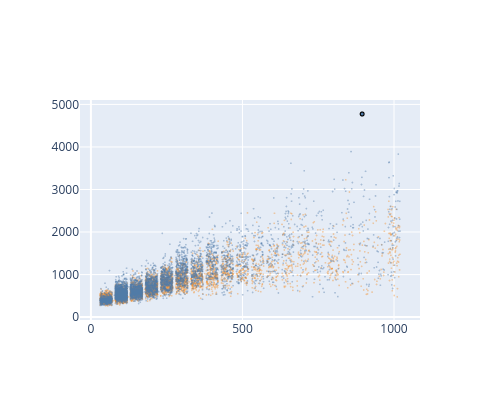

In [6]:
panelname = 'scater_full'
if panelname in panels:
    panels.pop(panelname)

for region in ['A1', 'PEG']:
    toplot = pivoted.query(f"region == '{region}'")
    x = toplot['last_bin_jittered'].values
    y = toplot['integral'].values

    xm, ym = get_quantile_means(x, y, 5000)

    panels[panelname].append(go.Scattergl(x=xm, y=ym,
                                          mode='markers',
                                          opacity=0.5,
                                          marker=dict(
                                              color=REGION_COLORMAP[region],
                                              opacity=0.8,
                                              size=2
                                          ),
                                          hoverinfo='skip',
                                          showlegend=False)
                             )

## highlight the special cell, defined in the first cell of the notebook
celltoplot = toplot.query(f"id == '{cellid}' and context_pair == '{ctx_pair[0]:02}_{ctx_pair[1]:02}' and "
                          f"probe == {probe}")

panels[panelname].append(go.Scattergl(x=celltoplot['last_bin_jittered'],
                                      y=celltoplot["integral"],
                                      mode='markers',
                                      marker=dict(color=REGION_COLORMAP[celltoplot['region'].values[0]],
                                                  size=4,
                                                  line=dict(color='black',
                                                            width=1)),
                                      hoverinfo='skip',
                                      showlegend=False)
                         )

fig = go.Figure()
pan = panels[panelname]
fig.add_traces(pan)
img_bytes = fig.to_image(format="png", width=500, height=400)
Image(img_bytes)

In [7]:
# count number of instances that are being compared, their mean and standard deviations
inst_by_reg = pivoted.groupby('region').agg(inst_count=('integral', 'count'), neu_count=('id', pd.Series.nunique))
print(inst_by_reg)


inst_by_trans = pivoted.groupby('trans_pair').agg(inst_count=('integral', 'count'), neu_count=('id', pd.Series.nunique))
print('\n', inst_by_trans)
print('\n',inst_by_reg.sum())


        inst_count  neu_count
region                       
A1           24711        709
PEG          21194        524

               inst_count  neu_count
trans_pair                         
diff_diff          25239        992
diff_same           7657        946
diff_silence       11243       1019
same_silence        1766        724

 inst_count    45905
neu_count      1233
dtype: int64


In [10]:
reg_summary = DF.groupby(['region', 'metric']).agg(
    mean=('value', np.mean), std=('value', np.std), sem=('value', sst.sem))
trans_summary = DF.groupby(['trans_pair', 'metric']).agg(
    mean=('value', np.mean), std=('value', np.std), sem=('value', sst.sem))
full_summary = DF.groupby(['metric']).agg(
    mean=('value', np.mean), std=('value', np.std), sem=('value', sst.sem))

print(reg_summary)
print(trans_summary)
print(full_summary)

                       mean         std       sem
region metric                                    
A1     integral  741.791788  530.229925  3.373021
       last_bin  244.965805  213.253093  1.356595
PEG    integral  866.944753  669.627035  4.599668
       last_bin  254.248243  203.160760  1.395413
                             mean         std        sem
trans_pair   metric                                     
diff_diff    integral  762.765264  534.340681   3.363428
             last_bin  233.786300  192.070630   1.208948
diff_same    integral  730.838435  523.832943   5.986369
             last_bin  238.193810  200.848097   2.295294
diff_silence integral  922.227801  744.981932   7.025943
             last_bin  285.916933  236.992378   2.234982
same_silence integral  842.794113  689.807240  16.414679
             last_bin  284.796149  242.513136   5.770852
                mean         std       sem
metric                                    
integral  799.573989  601.871862  2.809144
l

### formate strigs to copy paste into paper

In [53]:
# metrics by region
toprint = reg_summary.swaplevel(0,1)
for metric in toprint.index.levels[0]:
    inner = reg_summary.swaplevel(0,1).loc[metric,:]
    str_parts = list()
    for tp, vals in inner.iterrows():
        str_parts.append(f"{tp}: {vals.loc['mean']:.2f}±{vals.loc['sem']:.2f}")

    if metric == 'integral':
        units = 'ms*T-score'
    elif metric == 'last_bin':
        units = 'ms'

    full_str = f'{metric} mean±SEM. ' + ', '.join(str_parts) + units
    print(full_str)

integral mean±SEM. A1: 741.79±3.37, PEG: 866.94±4.60ms*T-score
last_bin mean±SEM. A1: 244.97±1.36, PEG: 254.25±1.40ms


In [52]:
# metrics by context pair
toprint = trans_summary.swaplevel(0,1)
for metric in toprint.index.levels[0]:
    inner = trans_summary.swaplevel(0,1).loc[metric,:]
    str_parts = list()
    for tp, vals in inner.iterrows():
        str_parts.append(f"{tp}: {vals.loc['mean']:.2f}±{vals.loc['sem']:.2f}")

    if metric == 'integral':
        units = 'ms*T-score'
    elif metric == 'last_bin':
        units = 'ms'

    full_str = f'{metric} mean±SEM. ' + ', '.join(str_parts) + units
    print(full_str)

integral mean±SEM. diff_diff: 762.77±3.36, diff_same: 730.84±5.99, diff_silence: 922.23±7.03, same_silence: 842.79±16.41ms*T-score
last_bin mean±SEM. diff_diff: 233.79±1.21, diff_same: 238.19±2.30, diff_silence: 285.92±2.23, same_silence: 284.80±5.77ms


## barplots of statistical analysis

integral, transition
same_silence vs diff_silence MannwhitneyU 2.1855844387811057e-07
same_silence vs diff_same MannwhitneyU 8.021074096468862e-10
same_silence vs diff_diff MannwhitneyU 0.0008585658644336377
diff_silence vs diff_same MannwhitneyU 2.772408584205676e-85
diff_silence vs diff_diff MannwhitneyU 1.87177411166506e-76
diff_same vs diff_diff MannwhitneyU 1.56304889514165e-11
integral, region
last_bin, transition
same_silence vs diff_silence MannwhitneyU 0.17606544828713783
same_silence vs diff_same MannwhitneyU 7.434985943365848e-11
same_silence vs diff_diff MannwhitneyU 4.4875835531044143e-13
diff_silence vs diff_same MannwhitneyU 3.203633387556092e-40
diff_silence vs diff_diff MannwhitneyU 6.632966611309865e-72
diff_same vs diff_diff MannwhitneyU 0.3558301294802876
last_bin, region


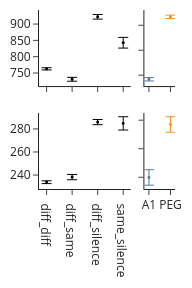

In [94]:
# for metric in ["integral", "last_bin"],:
def plot_metric_quant_bars(metric, category):
    print(f'{metric}, {category}')
    tocalc = DF.query(f"metric == '{metric}' and value > 0")
    # tocalc = tocalc.groupby(['trans_pair', 'region', 'id']).agg(value=('value', 'mean')).reset_index()
    tocalc = tocalc.replace({'silence_diff': 'sile_diff', 'silence_same': 'sile_same'})

    if category == 'transition':
        ### transitions ###
        toplot = tocalc.groupby('trans_pair').agg(stat=('value', np.mean),
                                                  err=('value', sst.sem))

        for c0,c1 in itt.combinations(tocalc.trans_pair.unique().tolist(), 2):
            x = tocalc.loc[tocalc.trans_pair == c0, 'value'].values.astype(float)
            y = tocalc.loc[tocalc.trans_pair == c1, 'value'].values.astype(float)
            stat, pval = sst.mannwhitneyu(x,y)
            print(f'{c0} vs {c1} MannwhitneyU {pval}')

        return [
            go.Scatter(x=toplot.index, y=toplot['stat'], mode='markers',
                       marker=dict(color='black',
                                   size=3),
                       error_y=dict(array=toplot['err'],
                                    color=name_to_hex('black'),
                                    thickness=1,
                                    width=5),
                       showlegend=False)
        ]

    ### regions ###
    elif category == 'region':
        x = tocalc.loc[tocalc.region == 'A1', 'value'].values.astype(float)
        y = tocalc.loc[tocalc.region == 'PEG', 'value'].values.astype(float)
        stat, pval = sst.mannwhitneyu(x,y)
        toplot = tocalc.groupby('region').agg(stat=('value', np.mean),
                                              err=('value', sst.sem))

        # if you want different color error bars, have to do it one at a time
        reg_quant = list()
        for ii, color in enumerate([Blue, Orange]):
            reg_quant.append(go.Scatter(x=(toplot.index[ii],), y=(toplot['stat'][ii],), mode='markers',
                                        marker=dict(color=color,
                                                    size=3),
                                        error_y=dict(array=toplot['err'],
                                                     color=color,
                                                     thickness=1,
                                                     width=5),
                                        showlegend=False),
                             )

        return reg_quant
    else:
        raise ValueError(f'bad param {category}')

fig = make_subplots(2,2, column_width=[0.75,0.25])
for mm, met in enumerate(['integral', 'last_bin']):
    for cc, cat in enumerate(['transition', 'region']):

        panelname = f'{met}_{cat}'

        if panelname in panels:
            panels.pop(panelname)

        panels[panelname].extend(plot_metric_quant_bars(met, cat))


        pan = panels[panelname]
        fig.add_traces(pan, cols=[cc+1]*len(pan), rows=[mm+1]*len(pan))


fig.update_layout(template='simple_white',
                  width=96*2, height=96*3,
                  margin=dict(l=10, r=10, t=10, b=10),
                  xaxis=dict(showticklabels=False),
                  xaxis2=dict(showticklabels=False),
                  yaxis2=dict(showticklabels=False),
                  yaxis4=dict(showticklabels=False),
                  )

img_bytes = fig.to_image(format="png")
Image(img_bytes)

# merges all the parts in a single figure

In [95]:
# simple plot layout and other figurewide configurations

def define_subplots():
    fig = make_subplots(rows=2,cols=3, vertical_spacing=0.05, horizontal_spacing=0.05,
                        column_widths=[0.6, 0.3, 0.1],
                        specs=[[{'rowspan':2, 'r':0.1}, {}, {}],
                               [None                  , {}, {}]])
    # figure size in inches at different PPIs
    ppi = 96 # www standard

    heigh = 3
    width = 4 # in inches
    _ = fig.update_layout(template='simple_white',
                          margin=dict(l=10, r=10, t=10, b=10),
                          width=round(ppi*width), height=round(ppi*heigh),

                          xaxis=dict(title=dict(
                              text='last bin (ms)',
                              standoff=0,
                              font_color=DURCOLOR)
                          ),

                          yaxis=dict(title=dict(
                              text="integral (d'*ms)",
                              standoff=0,
                              font_color=AMPCOLOR)
                          ),

                          xaxis2=dict(matches='x4',showticklabels=False),

                          yaxis2=dict(title=dict(
                              text="integral (d'*ms)",
                              font_color=AMPCOLOR,
                              standoff=0)
                          ),

                          xaxis3=dict(matches='x5',showticklabels=False),

                          yaxis3=dict(matches='y2',showticklabels=False),

                          xaxis4=dict(title=dict(text='context type pair', standoff=0), tickangle=-45,),

                          yaxis4=dict(title=dict(text='last bin (ms)', font_color=DURCOLOR, standoff=0)),

                          xaxis5=dict(title=dict(text='region', standoff=39)),

                          yaxis5=dict(matches='y4',showticklabels=False),

                          showlegend=False,
                          font_size=10,
                          )

    # add letter annotations for subplots
    anotations = [
        ('a', 0, 1),
        ('b', 0.5, 1),
        ('c', 0.87, 1),
        ('d', 0.5, 0.5),
        ('e', 0.87, 0.5),
    ]

    for letter, x, y in anotations:
        fig.add_annotation(x=x, y=y,
                           text=f'<b>{letter}</b>', font_size=12,
                           xref='paper', yref='paper',
                           xanchor='center', yanchor='middle',
                           showarrow=False)


    return fig, round(ppi*width), round(ppi*heigh)

f, pw, ph = define_subplots()
f.print_grid()
# img_bytes = f.to_image(format="png", width=pw, height=ph)
# Image(img_bytes)

This is the format of your plot grid:
⎡ (1,1) x,y   ⎤  [ (1,2) x2,y2 ]  [ (1,3) x3,y3 ]
⎣      :      ⎦  [ (2,2) x4,y4 ]  [ (2,3) x5,y5 ]



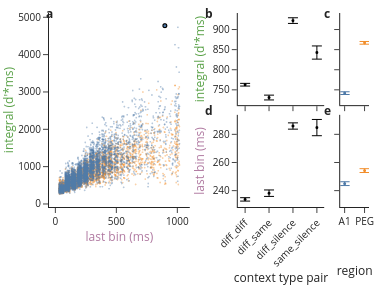

In [96]:
fig, pw, ph = define_subplots()

# scatter
pan = panels['scater_full']
fig.add_traces(pan, cols=[1]*len(pan), rows=[1]*len(pan))

# top left
pan = panels['integral_transition']
fig.add_traces(pan, cols=[2]*len(pan), rows=[1]*len(pan))

# top right
pan = panels['integral_region']
fig.add_traces(pan, cols=[3]*len(pan), rows=[1]*len(pan))

# bottom left
pan = panels['last_bin_transition']
fig.add_traces(pan, cols=[2]*len(pan), rows=[2]*len(pan))

# bottom right
pan = panels['last_bin_region']
fig.add_traces(pan, cols=[3]*len(pan), rows=[2]*len(pan))


img_bytes = fig.to_image(format="png", width=pw, height=ph)
Image(img_bytes)


# saves PNG and SVG

In [97]:
folder = root_path / 'reports' / 'figures' / 'paper'
folder.mkdir(parents=True, exist_ok=True)

filename = folder / 'figure_02'
fig.write_image(filename.with_suffix('.png'))
fig.write_image(filename.with_suffix('.svg'))